# 0. 기본
>   `y = w*x + b`
> 
> y는 종속변수로, 우리가 예측하고자 하는 값입니다.
> x는 독립변수로, 우리가 알고 있는 값입니다.
> w는 가중치로, x와 y 사이의 관계를 나타냅니다.
> b는 절편으로, y축에서 직선의 위치를 나타냅니다.

# 1. 라이브러리 불러오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# additional imports for ETC section.
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# allows matplotlib plots to be embedded within the notebook instead of opening in a new window.
%matplotlib inline

## 2. CUDA 사용 가능 여부 확인

In [2]:
print("CUDA is available?", torch.cuda.is_available())

CUDA is available? False


## 3. 데이터 불러오기

In [3]:
dataset = pd.read_csv('../data/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## 4. 그래프 설정 및 데이터 시각화

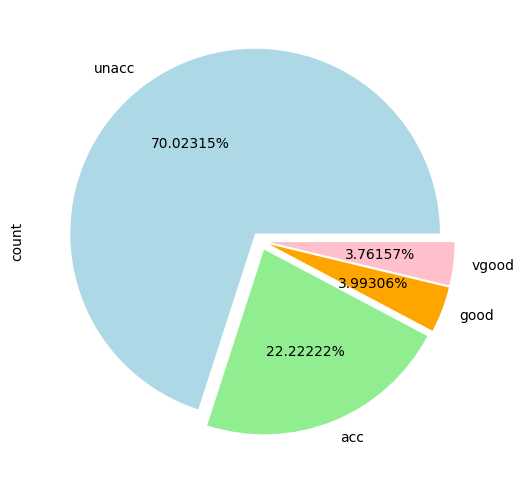

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6

plt.rcParams["figure.figsize"] = fig_size

dataset.output.value_counts().plot(kind="pie", autopct="%0.05f%%",
                                   colors=["lightblue", "lightgreen", "orange", "pink"],
                                   explode=(0.05, 0.05, 0.05, 0.05))

plt.show()

## 5. 데이터 전처리: 변수를 정수로 인코딩 및 전처리된 데이터를 숫자로 변환

In [5]:
category_col = ["price", "maint", "doors", "persons", "lug_capacity", "safety"]

for category in category_col:
    dataset[category] = dataset[category].astype("category")

price = dataset["price"].cat.codes.values
maint = dataset["maint"].cat.codes.values
doors = dataset["doors"].cat.codes.values
persons = dataset["persons"].cat.codes.values
lug_capacity = dataset["lug_capacity"].cat.codes.values
safety = dataset["safety"].cat.codes.values

category_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data = torch.tensor(category_data, dtype=torch.int64)

category_data[:10]  # Show part of converted dataset

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

## 6. 데이터 인코딩: 텐서로 변환

In [6]:
outputs = pd.get_dummies(dataset.output).values
outputs = torch.Tensor(outputs).flatten()

print("Categorical Data: \n", categorical_data, end="\n\n")
print("Output Shape: \n", outputs.shape)

Categorical Data: 
 tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        ...,
        [1, 1, 3, 2, 0, 1],
        [1, 1, 3, 2, 0, 2],
        [1, 1, 3, 2, 0, 0]])

Output Shape: 
 torch.Size([6912])


## 7. 임베딩 크기 설정

In [7]:
categorical_col_size = [len(dataset[column].cat.categories) for column in category_col]
categorical_embedding_size = [(col_size, min(50, (col_size + 1) // 2)) for col_size in categorical_col_size]

print("모든 범주형 칼럼의 고유 값 수, 차원의 크기")
print(categorical_embedding_size)

모든 범주형 칼럼의 고유 값 수, 차원의 크기
[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


## 8. 데이터 분할: 훈련, 테스트 데이터셋 분리

In [8]:
total_records = 1728
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]

train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [9]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


## 9. 모델 정의: 임베딩 레이어, 드롭아웃 레이어, 여러개의 레이어(ReLu, BatchNorm1d, Dropout)을 포함하여 모델 작성

In [10]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_embeddings = sum((nf for ni, nf in embedding_size))
        input_size = num_embeddings

        for layer in layers:
            all_layers.append(nn.Linear(input_size, layer))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(layer))
            all_layers.append(nn.Dropout(p))
            input_size = layer

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    # noinspection PyShadowingNames
    def forward(self, x_categorical):
        embeddings = []
        for index, embedding in enumerate(self.all_embeddings):
            embeddings.append(embedding(x_categorical[:, index]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

## 10. 모델 초기화 및 손실함수, 옵티마이저 정의

In [11]:
model = Model(categorical_embedding_size, 4, [200, 100, 50], p=0.4)
print(model)  # Layer 및 기타 정보 출력

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


- Layer 0 - 11 : for 안에서 생성됨
- Layer 12 : nn.Sequential 이전에 수동으로 Linear를 append함

## 11. 장치 설정: CPU GPU 중 사용 가능한 장치를 선택

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Set to GPU")
else:
    device = torch.device("cpu")
    print("Set to CPU")

Set to CPU


## 12. 모델 학습

In [13]:
epochs = 500
aggregated_losses = []
train_outputs: torch.Tensor = train_outputs.to(device, dtype=torch.int64)

single_loss = None
i = 0

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i % 25 == 1:
        print(f"epoch : {i:3} loss : {single_loss.item():10.8f}")

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch :   1 loss : 1.59571445
epoch :  26 loss : 1.41739666
epoch :  51 loss : 1.30745482
epoch :  76 loss : 1.20970535
epoch : 101 loss : 1.08085108
epoch : 126 loss : 0.92955005
epoch : 151 loss : 0.82144761
epoch : 176 loss : 0.73993933
epoch : 201 loss : 0.70002592
epoch : 226 loss : 0.64894998
epoch : 251 loss : 0.62848276
epoch : 276 loss : 0.61612058
epoch : 301 loss : 0.60184991
epoch : 326 loss : 0.59095609
epoch : 351 loss : 0.59205031
epoch : 376 loss : 0.58263314
epoch : 401 loss : 0.57981366
epoch : 426 loss : 0.57076919
epoch : 451 loss : 0.57937676
epoch : 476 loss : 0.56921154
epoch: 500 loss: 0.5730313659


## 13. 테스트 및 성능 측정

> 테스트 데이터셋을 이용하여 모델 테스트

In [14]:
# 테스트 데이터셋을 통한 예측
test_outputs = test_outputs.to(device, dtype=torch.int64)

with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

# 실행 결과가 매번 다를 수 있음
y_val = np.argmax(y_val, axis=1)
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

Loss: 0.56638241
[[257   2]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.85       259
           1       0.00      0.00      0.00        86

    accuracy                           0.74       345
   macro avg       0.37      0.50      0.43       345
weighted avg       0.56      0.74      0.64       345

0.744927536231884


# ETC. 꽃 특징 예측하기 (Iris)
> 실행시 결과가 다를 수 있음

In [33]:
# Iris 데이터셋의 특성 이름을 리스트로 저장
names = ["sepal-length", "sepal-width", "petal-length", "petal-width", "Class"]

# 데이터 불러오기
dataset = pd.read_csv('../data/iris.data', names=names)

# 독립변수와 종속변수 분리
x = dataset.iloc[:, :-1].values  # 이름을 제외한 값들 (추측을 위한 값)
y = dataset.iloc[:, 4].values  # 이름 (찾을 값)

# 데이터를 훈련 세트와 테스트 세트로 분리함 (데이터의 순서가 무작위로 바뀔 수 있음)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# 표준화 작업
# 원래 5.1,3.3,1.7,0.5 같은 큰 값을 0에 가깝게 변환
s = StandardScaler()

# 서로의 관계를 유지하면서 숫자를 0에 가깝게 만듬
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

# KNN 모델 생성 및 학습
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train, y_train)

### 예측 및 성능 평가
# 제공된 데이터에 대한 클래스 레이블을 예측합니다.
y_pred: np.ndarray = knn.predict(x_test)  # y_pred는 예측된 이름을 가지고 있으며, 이것이 정답인지는 아직 알지 못합니다.
print("정확도: ", accuracy_score(y_test, y_pred))  # 정확도는 실행할 때마다 달라질 수 있습니다. [ train_test_split() 때문에 ]

정확도:  0.8333333333333334


- 아래 코드는 K-최근접 이웃(K-Nearest Neighbors, KNN) 분류기의 최적의 K값을 찾는 것입니다.
- KNN 분류기는 주어진 데이터 포인트의 클래스를 예측하기 위해 K개의 가장 가까운 이웃을 찾습니다.
- 이 K값 선택은 KNN 분류기의 성능에 많은 영향을 미치므로 이 코드에서는 다른 K 값에 대한 분류기의 정확도를 비교합니다.
    - 1. k = 10에서는 K값의 최대 범위를 설정합니다. 그래서 우리는 K = 1에서 K = 10까지의 모든 값을 시도해봅니다.
    - 2. acc_array는 각 K값에 대한 정확도를 저장하는 numpy 배열입니다.
    - 3. for loop에서는 K값이 1에서 10까지 변하며 KNN 분류기를 학습하고, 테스트 데이터 세트에 대한 예측을 합니다.
    - 4. accuracy_score 함수는 예측한 값 y_pred와 실제 값 y_test를 비교하여 정확도를 계산합니다. 이 결과는 acc_array에 저장됩니다.
    - 5. 모든 K에 대한 정확도가 계산되면, np.amax 함수를 사용하여 최대 정확도를 찾습니다.
    - 6. 그리고 최대 정확도를 갖는 K 값을 찾기 위해, acc_list.index(max_acc)를 사용하여 최대 정확도를 가진 인덱스를 찾습니다. 인덱스는 0부터 시작하기 때문에, 이는 K-1 값에 해당하며, 순환문에서 K-1의 각 값에 대해 정확도를 계산하므로, 이를 통해 우리는 최대 정확도를 가진 K값을 얻게 됩니다.
    - 7. 마지막으로, 최대 정확도와 이 때의 K값을 출력합니다.
> 요약하면 이 코드는 KNN 분류기의 최적의 K값을 찾기 위해 다양한 K값에 대한 모델의 정확도를 시험하고, 가장 높은 정확도를 보여준 K값과 그 때의 정확도를 출력합니다.

In [16]:
k = 10
acc_array = np.zeros(k)

for k in np.arange(1, k + 1, 1):
    classifier = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    acc_array[k - 1] = acc

max_acc = np.amax(acc_array)
acc_list = list(acc_array)
k = acc_list.index(max_acc)
print("정확도: ", max_acc, "최적의 k: ", k)

정확도:  0.9666666666666667 최적의 k:  6


In [39]:
a, b, c, d = map(float, input("꽃의 특징값 4개를 입력하세요 (공백으로 구분): ").split())
print("예측된 꽃은", knn.predict(s.transform([[a, b, c, d]]))[0], "입니다.")

예측된 꽃은 Iris-versicolor 입니다.
